In [1]:
import netCDF4 as nc
from matplotlib import pyplot as plt
import numpy as np
import glob
import pickle
from salishsea_tools import evaltools as et
import datetime as dt
import os
import re
import cmocean
%matplotlib inline

In [2]:
ignorelist=('nav_lat','nav_lon', 'bounds_nav_lon', 'bounds_nav_lat', 'area', 'bounds_lon','bounds_lat',
            'deptht', 'deptht_bounds', 'time_centered', 'time_centered_bounds', 
            'time_counter', 'time_counter_bounds','nav_lat_grid_T', 'nav_lon_grid_T', 
            'bounds_nav_lon_grid_T', 'bounds_nav_lat_grid_T', 'area_grid_T', 
            'nav_lat_grid_W', 'nav_lon_grid_W', 'bounds_nav_lon_grid_W', 
            'bounds_nav_lat_grid_W', 'area_grid_W', 'time_centered', 'time_centered_bounds',
            'depthu', 'depthu_bounds','depthv', 'depthv_bounds','depthw', 'depthw_bounds',
            'layer6m_W', 'layer6m_W_bounds','bounds_lon_grid_T','bounds_lat_grid_T',
            'bounds_lon_grid_W','bounds_lat_grid_W','time_instant_bounds','time_instant')
def checkall(ff):
    fkeys=ff.variables.keys()
    print('fP.variables.keys():',fkeys)
    print('Min/Max:')
    for var in fkeys:
        if var not in ignorelist:
            #print(var)
            if len(np.shape(ff.variables[var]))==4:
                print(var,':',np.min(np.ma.masked_where(tmask[:,:,:]==0,ff.variables[var][-1,:,:,:])),
                      np.max(np.ma.masked_where(tmask[:,:,:]==0,ff.variables[var][-1,:,:,:])))
            elif len(np.shape(ff.variables[var]))==3:
                print(var,':',np.min(np.ma.masked_where(tmask[0,:,:]==0,ff.variables[var][-1,:,:])),
                      np.max(np.ma.masked_where(tmask[0,:,:]==0,ff.variables[var][-1,:,:])))
            else: 
                print('unknown shape: ',var,len(np.shape(ff.variables[var])))
def checkallSlice(ff):
    fkeys=ff.variables.keys()
    print('fP.variables.keys():',fkeys)
    print('Min/Max:')
    for var in fkeys:
        if var not in ignorelist:
            print(var,':',np.min(ff.variables[var][-1,:,:,:]),
                      np.max(ff.variables[var][-1,:,:,:]))

In [3]:
with nc.Dataset('/ocean/eolson/MEOPAR/NEMO-forcing/grid/mesh_mask201702_noLPE.nc') as mesh:
    tmask=mesh.variables['tmask'][0,:,:,:]
    e1t=np.expand_dims(mesh.variables['e1t'][:,:,:],1)
    e2t=np.expand_dims(mesh.variables['e2t'][:,:,:],1)
    z=mesh.variables['gdept_1d'][0,:]
    e3t_1d=mesh.variables['e3t_1d'][0,:]
SOGtmaskPath='/ocean/eolson/MEOPAR/northernNO3PaperCalcs/save/SOGtmask.pkl'
(tmaskSOG,_,_,_,_)=pickle.load(open(SOGtmaskPath,'rb'))

In [4]:
idir='/data/sallen/results/MEOPAR/fluxes_elise_2/'
ts=dt.datetime(2015,1,1)
te=dt.datetime(2017,12,31)

In [5]:
fPlist=et.index_model_files_flex(idir,'dian_T','1d','nowcast',ts,te)

In [6]:
fPlist.tail()

,paths,t_0,t_n
211,/data/sallen/results/MEOPAR/fluxes_elise_2/06d...,2017-12-06,2017-12-11
212,/data/sallen/results/MEOPAR/fluxes_elise_2/11d...,2017-12-11,2017-12-16
213,/data/sallen/results/MEOPAR/fluxes_elise_2/16d...,2017-12-16,2017-12-21
214,/data/sallen/results/MEOPAR/fluxes_elise_2/21d...,2017-12-21,2017-12-26
215,/data/sallen/results/MEOPAR/fluxes_elise_2/26d...,2017-12-26,2018-01-01


In [7]:
with nc.Dataset(fPlist.paths[0]) as ff:
    checkall(ff)

fP.variables.keys(): dict_keys(['nav_lat', 'nav_lon', 'bounds_lon', 'bounds_lat', 'area', 'deptht', 'deptht_bounds', 'NO3RAD', 'time_centered', 'time_centered_bounds', 'time_counter', 'time_counter_bounds', 'RIV_NO3', 'RIV_NH4', 'REM_NO3', 'REM_PON', 'REM_DON', 'PRD_NO3', 'PRD_NH4', 'REFRN'])
Min/Max:
NO3RAD : 0.0 0.0
RIV_NO3 : 0.0 4302.5117
RIV_NH4 : 0.0 2210.7188
REM_NO3 : 0.0 1.1682037
REM_PON : -0.77527034 -0.0
REM_DON : -1.1512139 -0.0
PRD_NO3 : -0.5814207 -0.0
PRD_NH4 : -0.22910036 -0.0
REFRN : -1.9300626e-06 2.3530053e-21


In [21]:
prdNO3Sum=list(); 
prdNH4Sum=list();

for i,r in fPlist.iterrows():
    with nc.Dataset(r['paths']) as f:
        prdNO3Sum.append(np.mean(np.sum(np.ma.masked_where(tmaskSOG*np.ones(np.shape(f.variables['PRD_NO3'][:,:,:,:]))==0,
                                        f.variables['PRD_NO3'][:,:,:,:]/(e1t*e2t)),1),(1,2)))
        prdNH4Sum.append(np.mean(np.sum(np.ma.masked_where(tmaskSOG*np.ones(np.shape(f.variables['PRD_NO3'][:,:,:,:]))==0,
                                        f.variables['PRD_NH4'][:,:,:,:]/(e1t*e2t)),1),(1,2)))
prdNO3Sum=-1*24*3600*np.concatenate(prdNO3Sum,axis=0)*1.11# should not have x24*3600; was mmol/s; want mmol/m2/s
prdNH4Sum=-1*24*3600*np.concatenate(prdNH4Sum,axis=0)*1.11

In [22]:
prdNO3Sum2=list(); 
prdNH4Sum2=list();

for i,r in fPlist.iterrows():
    with nc.Dataset(r['paths']) as f:
        prdNO3Sum2.append(np.sum(np.sum(np.ma.masked_where(tmaskSOG*np.ones(np.shape(f.variables['PRD_NO3'][:,:,:,:]))==0,
                                        f.variables['PRD_NO3'][:,:,:,:]),1),(1,2))/np.sum(np.ma.masked_where(tmaskSOG[:,0,:,:]==0,e1t[:,0,:,:]*e2t[:,0,:,:],(1,2))))
        prdNH4Sum2.append(np.sum(np.sum(np.ma.masked_where(tmaskSOG*np.ones(np.shape(f.variables['PRD_NO3'][:,:,:,:]))==0,
                                        f.variables['PRD_NH4'][:,:,:,:]),1),(1,2))/np.sum(np.ma.masked_where(tmaskSOG[:,0,:,:]==0,e1t[:,0,:,:]*e2t[:,0,:,:]),(1,2)))
prdNO3Sum2=-1*24*3600*np.concatenate(prdNO3Sum2,axis=0)*1.11
prdNH4Sum2=-1*24*3600*np.concatenate(prdNH4Sum2,axis=0)*1.11

In [32]:
# correct and go from mmol to nmol:
prdNO3Sum2=prdNO3Sum2/(24*3600)*1e6
prdNH4Sum2=prdNH4Sum2/(24*3600)*1e6
prdNO3Sum=prdNO3Sum/(24*3600)*1e6
prdNH4Sum=prdNH4Sum/(24*3600)*1e6

Text(0.5, 1.0, 'nmol N /m2/s')

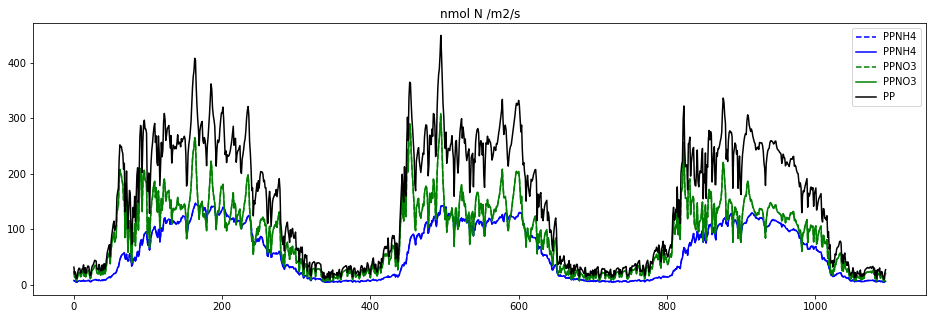

In [36]:
fig,ax=plt.subplots(1,1,figsize=(16,5))
ax.plot(range(0,len(prdNO3Sum)),prdNH4Sum,'b--',label='PPNH4')
ax.plot(range(0,len(prdNO3Sum)),prdNH4Sum2,'b-',label='PPNH4')
ax.plot(range(0,len(prdNO3Sum)),prdNO3Sum,'g--',label='PPNO3')
ax.plot(range(0,len(prdNO3Sum)),prdNO3Sum2,'g-',label='PPNO3')
ax.plot(range(0,len(prdNO3Sum)),prdNO3Sum+prdNH4Sum,'k-',label='PP')
ax.legend()
ax.set_title('nmol N /m2/s')
# mmol N/m2/s

In [37]:
PP=prdNO3Sum+prdNH4Sum

In [38]:
np.shape(PP)

(1096,)

In [39]:
#May is 121:151, 121+366:151+366, 121+366+365:151+366+365
np.mean(PP[121:151]),np.mean(PP[121+366:151+366]),np.mean(PP[121+366+365:151+366+365])

(262.330044399155, 285.71874550283917, 248.71040557040695)

In [40]:

np.mean(PP[121-30:151-30]),np.mean(PP[121+366-30:151+366-30]),np.mean(PP[121+366+365-30:151+366+365-30])

(238.43120137054245, 245.22518664594807, 219.21922612163752)

In [41]:

np.mean(PP[121-60:151-60]),np.mean(PP[121+366-60:151+366-60]),np.mean(PP[121+366+365-60:151+366+365-60])

(178.79208512622844, 163.5068102495571, 103.17335982919172)

In [42]:

np.mean(PP[121+30:151+30]),np.mean(PP[121+366+30:151+366+30]),np.mean(PP[121+366+365+30:151+366+365+30])

(285.697451904132, 243.82023039889955, 246.1175310098107)

In [43]:
#Jan is 0:31, 366:31+151+366, 366+365:31+151+366+365
np.mean(PP[0:31]),np.mean(PP[366:31+151+366]),np.mean(PP[366+365:31+151+366+365])

(28.119178260840282, 167.90144096561295, 148.10896863586666)